## Imports

In [1]:
import pathlib
import PIL.Image
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import glob
import random

import splitfolders
import os, shutil

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16, ResNet50


## Read Image Data

In [2]:
print('Num GPUs Available: ', len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
#Set data directory
data_dir = pathlib.Path('./data')

In [4]:
#show number of images included in directory
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

2527


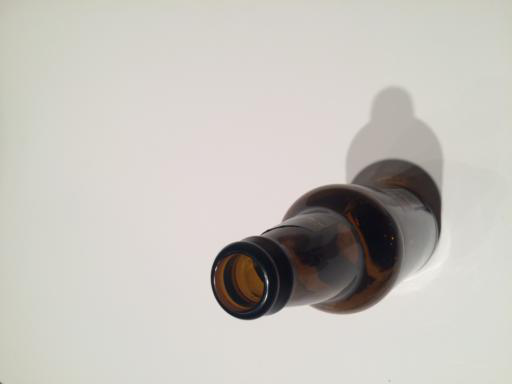

In [5]:
#Display a sample glass image
glass = list(data_dir.glob('glass/*'))
PIL.Image.open(str(glass[0]))

## Load Dataset

In [6]:
#Define some parameters for the loader:
batch_size = 32
img_height = 384
img_width = 512

#TODO: Resize to smaller size

In [7]:
# #clear images folder
folder = './images'
for filename in os.listdir(folder):
    file_path = os.path.join(folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

In [8]:
def train_test_split_folders(data_dir):
    splitfolders.ratio(data_dir, output="images", seed=1337, ratio=(.8, 0.1,0.1))
    image_dir = 'images'

    #create training split  
    train_ds = tf.keras.utils.image_dataset_from_directory(
    image_dir + '/train',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

    #create validation split
    val_ds = tf.keras.utils.image_dataset_from_directory(
    image_dir + '/val',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

    #create validation split
    test_ds = tf.keras.utils.image_dataset_from_directory(
    image_dir + '/test',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = train_test_split_folders(data_dir=data_dir)

Copying files: 2527 files [00:12, 197.92 files/s]


Found 2019 files belonging to 6 classes.
Found 251 files belonging to 6 classes.
Found 257 files belonging to 6 classes.


In [9]:
#Show names of the found classes
class_names = train_ds.class_names
num_classes = len(class_names)

print(class_names)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


## Configure the ds

*Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:*

    - Ds.cache keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
    
    - Dataset.prefetch overlaps data preprocessing and model execution while training.

*Interested readers can learn more about both methods, as well as how to cache data to disk in the Prefetching section of the Better performance with the tf.data API guide.*

## Standardize the data

In [10]:
# intializing rescaling layer to map onto data in the next step
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [11]:
# creating the normalized dataset
 
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in '[0, 1]'
print(np.min(first_image), np.max(first_image))

0.078431375 1.0


In [12]:
AUTOTUNE = tf.data.AUTOTUNE

#load data into cache to reduce i/o
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Define Model 1

In [13]:
# Load the pre-trained model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(384, 512,  3))

# Freeze the layers
for layer in base_model.layers:
    layer.trainable = False

# Add a new layer
x = layers.Flatten()(base_model.output)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(num_classes, activation='softmax')(x)

# Create the model
model = tf.keras.models.Model(inputs=base_model.input, outputs=output)

58889256/58889256 [==============================] - 9s 0us/step


In [14]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
# Train the model
history = model.fit(train_ds,
                    epochs=5,
                    validation_data=val_ds)

Epoch 1/5


c:\Users\Felix\anaconda3\envs\tfdml_plugin\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


64/64 [==============================] - 29s 403ms/step - loss: 3.0996 - accuracy: 0.3472 - val_loss: 1.3553 - val_accuracy: 0.4861
Epoch 2/5
64/64 [==============================] - 25s 395ms/step - loss: 1.9888 - accuracy: 0.3952 - val_loss: 1.3284 - val_accuracy: 0.4900
Epoch 3/5
64/64 [==============================] - 25s 393ms/step - loss: 1.6989 - accuracy: 0.3997 - val_loss: 1.3408 - val_accuracy: 0.4661
Epoch 4/5
64/64 [==============================] - 25s 393ms/step - loss: 1.6643 - accuracy: 0.4165 - val_loss: 1.2674 - val_accuracy: 0.5179
Epoch 5/5
64/64 [==============================] - 25s 393ms/step - loss: 1.4977 - accuracy: 0.4235 - val_loss: 1.2993 - val_accuracy: 0.4940


In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 384, 512, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 384, 512, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 384, 512, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 192, 256, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 192, 256, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 192, 256, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 96, 128, 128)      0     

In [17]:
date = datetime.today().strftime("%Y-%m-%d_%H-%M")

In [20]:
# save as tlite model 
# Convert the model.
convert_model = True

if convert_model:
      with open("./models/trash_classes.txt", "w") as f:
            for cls in class_names:
                  f.write(cls + "\n")
      
      converter = tf.lite.TFLiteConverter.from_keras_model(model)
      tflite_model = converter.convert()

      # Save the model.
      with open(f'./models/transfer_model_tflite_{date}.tflite', 'wb') as f:
            f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Felix\AppData\Local\Temp\tmp6tbjjwgs\assets


INFO:tensorflow:Assets written to: C:\Users\Felix\AppData\Local\Temp\tmp6tbjjwgs\assets


In [21]:
# save model
save_model = False
if save_model:      
      model.save(f'./models/model_{date}')

In [22]:
#export training history
save = False

if save:
    np.save('test2_history.npy',history.history)

In [23]:
#import training history
load = False

if load:
    history=np.load('my_history.npy',allow_pickle='TRUE').item()

In [24]:
def plot_history_acc(history):
    # summarize history for accuracy
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.savefig('history_acc.png')
    
plot_history_acc(history)


TypeError: 'History' object is not subscriptable

In [25]:
def plot_history_loss(history):
    # summarize history for loss
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.savefig('history_loss.png')
    
plot_history_loss(history)

TypeError: 'History' object is not subscriptable

Predictions:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1]
Labels:
 [3 3 2 0 1 4 1 0 1 1 3 2 2 1 1 5 0 3 0 4 1 2 4 1 0 3 2 3 0 3 3 1]


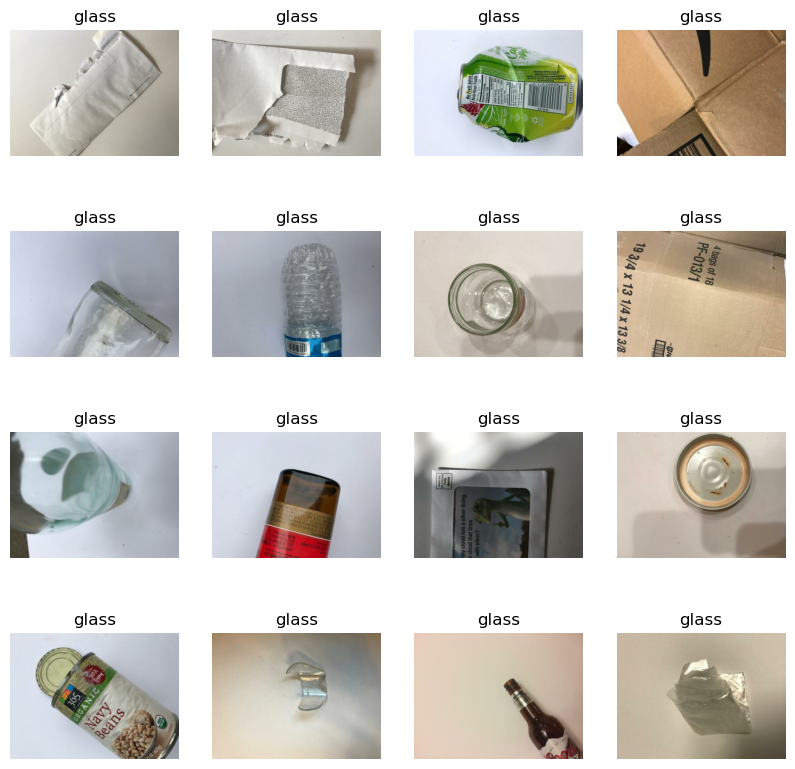

In [26]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## Model 2

In [28]:
# Load the pre-trained model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(384, 512, 3))

# Freeze the layers
for layer in base_model.layers[:-1]:
    layer.trainable = False

# Add a new layer
x = layers.GlobalAveragePooling2D()(base_model.output)
output = layers.Dense(num_classes, activation='softmax')(x)

# Create the model
model = tf.keras.models.Model(inputs=base_model.input, outputs=output)

94765736/94765736 [==============================] - 14s 0us/step


In [29]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [30]:
# Train the model
history = model.fit(train_ds,
                    epochs=5,
                    validation_data=val_ds)

Epoch 1/5


c:\Users\Felix\anaconda3\envs\tfdml_plugin\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


64/64 [==============================] - 33s 470ms/step - loss: 1.0229 - accuracy: 0.6246 - val_loss: 0.7446 - val_accuracy: 0.7331
Epoch 2/5
64/64 [==============================] - 29s 458ms/step - loss: 0.5238 - accuracy: 0.8247 - val_loss: 0.6127 - val_accuracy: 0.7888
Epoch 3/5
64/64 [==============================] - 29s 458ms/step - loss: 0.4109 - accuracy: 0.8697 - val_loss: 0.5644 - val_accuracy: 0.7849
Epoch 4/5
64/64 [==============================] - 29s 458ms/step - loss: 0.3481 - accuracy: 0.9004 - val_loss: 0.5365 - val_accuracy: 0.8167
Epoch 5/5
64/64 [==============================] - 29s 457ms/step - loss: 0.2967 - accuracy: 0.9123 - val_loss: 0.5068 - val_accuracy: 0.8327


In [37]:
# save as tlite model 
# Convert the model.
convert_model = True

if convert_model:
      with open("./models/trash_classes.txt", "w") as f:
            for cls in class_names:
                  f.write(cls + "\n")
      
      converter = tf.lite.TFLiteConverter.from_keras_model(model)
      tflite_model = converter.convert()

      # Save the model.
      with open(f'./models/transfer_model_tflite_{date}.tflite', 'wb') as f:
            f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Felix\AppData\Local\Temp\tmpqgmb6xjy\assets


INFO:tensorflow:Assets written to: C:\Users\Felix\AppData\Local\Temp\tmpqgmb6xjy\assets


In [36]:
img = tf.keras.utils.load_img("./images/test/plastic/plastic49.jpg")

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# print(
#     "This image most likely belongs to {} with a {:.2f} percent confidence."
#     .format(class_names[np.argmax(score)], 100 * np.max(score))
# )


1/1 [==============================] - 0s 21ms/step
This image most likely belongs to plastic with a 23.20 percent confidence.


1/1 [==============================] - 0s 20ms/step


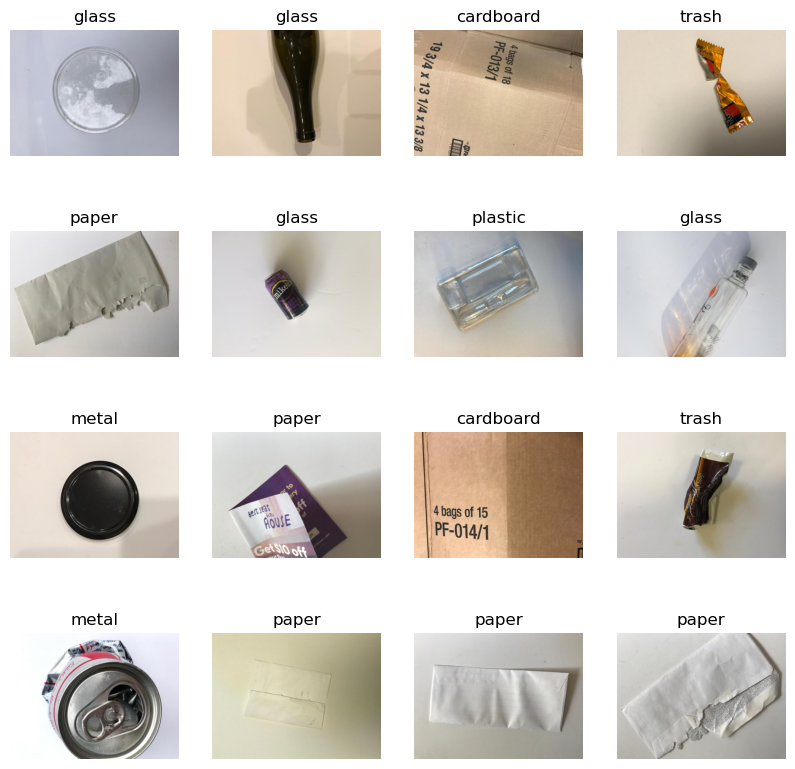

In [41]:
test_dir = "./images/test/"

test_files = glob.glob(test_dir + '/**/*', recursive = True)

random_test = random.sample(test_files,16)

plt.figure(figsize=(10, 10))
for i,image in enumerate(random_test):
    img = tf.keras.utils.load_img(image)
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(img)
    plt.title(class_names[np.argmax(score)])
    plt.axis("off")